cuda:0


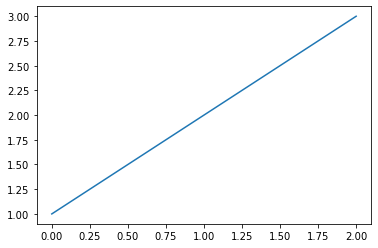

In [1]:
from matplotlib import pyplot as plt
plt.plot([1,2,3])
import numpy as np
import scipy
import scipy.spatial as spatial
import copy
from Environment.Builder_Env import Structure_Builder, circle, assignment
from RL.sac import sac_agent
import matplotlib
import torch
from Environment.data_visualization import show_reset, show_done, show_step, plot_large_frame
from Environment.episode_memory import Episode_Memory
from Environment.createc_control import Createc_Controller

matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [8]:
import importlib
import Environment.Builder_Env
importlib.reload(Environment.Builder_Env)
from Environment.Builder_Env import Structure_Builder

In [2]:
def RL_operation(env, agent, atom_chosen, next_destination_nm, anchor_chosen, offset_nm, len_nm, i_episode, max_steps=5):
    done = False
    state, info = env.reset(next_destination_nm, anchor_chosen, offset_nm, len_nm, large_len_nm)
        
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    
    for step in range(max_steps):
        print('step:', step)
        if np.linalg.norm(env.atom_absolute_nm - atom_chosen)>2:
            print('identify the wrong atom')
            break
            
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        mask = float(not done)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        state=next_state
        print('precision:', env.dist_destination, 'nm')
        show_step(env.img_info, info['start_nm']+env.atom_absolute_nm, info['end_nm']+env.atom_absolute_nm,env.atom_absolute_nm, 
                  env.atom_start_absolute_nm, env.destination_absolute_nm, 
                  action[4]*env.max_mvolt, action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, np.array([0,0]))
            episode_memory.save_memory(folder_name)
            break
    return env.atom_absolute_nm, env.dist_destination

In [3]:
batch_size= 64
LEARNING_RATE = 0.0003
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
weight_folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_0'
episode = 3600
agent.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(weight_folder_name, episode)))
agent.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(weight_folder_name, episode)))
agent.alpha = torch.load('{}/_alpha_{}.pth'.format(weight_folder_name, episode))
episode_memory = Episode_Memory()

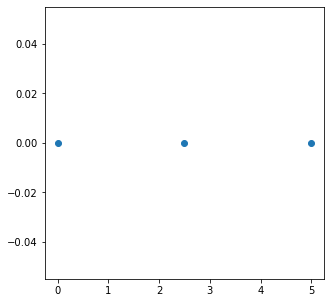

In [4]:
design_nm = np.array(list(zip(np.arange(0,7.5,2.5), np.zeros(3))))#np.array([[0, 0], [0, 2.5], [0,1.25]])
plt.subplots(figsize=(5,5))
plt.scatter(design_nm[:,0], design_nm[:,1])

In [5]:
#test offset extration
createc_controller = Createc_Controller(None, None, None, None)
DAC_unit = 2**19
volt_unit = 10
Xgain = float(createc_controller.stm.getparam("GainX"))
Ygain = float(createc_controller.stm.getparam("GainY"))
Xpiezoconst = float(createc_controller.stm.getparam("Xpiezoconst"))
Ypiezoconst = float(createc_controller.stm.getparam("Ypiezoconst"))
x_nm = -0.1*Xpiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetX'))*Xgain/DAC_unit
y_nm = -0.1*Ypiezoconst*volt_unit*float(createc_controller.stm.getparam('OffsetY'))*Ygain/DAC_unit
print(x_nm, y_nm)

step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 4
large_len_nm = 8.033
large_offset_nm = np.array([x_nm, y_nm])
pixel = 128
scan_mV = 1000
max_len = 5
speed = 1500
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/diamond_build'

env = Structure_Builder(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 current_jump, large_len_nm, large_offset_nm, pixel, scan_mV, max_len, speed = speed)

succeed to connect
-3.773761749267578 13.97817611694336
succeed to connect
speed: 1500


The scan will take 13.1 seconds


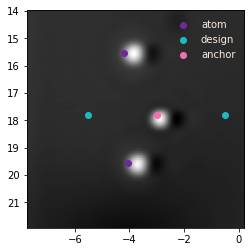

start: [-4.05464115 19.55804547] goal [-0.5 17.8]
Use anchor: True


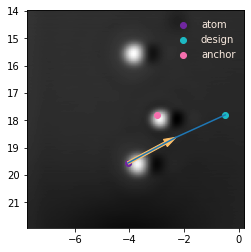

The scan will take 13.1 seconds
anchor from small scan: [-3.22535133 17.89402948] anchor from large scan: [-3.  17.8]


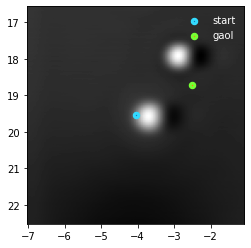

step: 0
63 62 100 47
Old prediction: True
Prediction: 0.5174727
cnn thinks there is atom movement
The scan will take 9.8 seconds
atom moves by: 1.2675570392932145
precision: 0.47963495435628933 nm


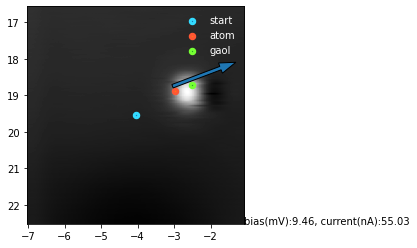

step: 1
94 46 98 47
Old prediction: False
Prediction: 0.4203026
Random scan
The scan will take 9.8 seconds


KeyboardInterrupt: 

In [9]:
num_steps = 10

atom_chosen, design_chosen, next_destination_nm, path, anchor_chosen, offset_nm, len_nm = env.reset_large(design_nm, 
                                                                                                          align_design_mode = 'auto')
np.save(folder_name+'/{}_episode_img_info.npy'.format(-1),env.large_img_info)
for i in range(0, num_steps):
    plot_large_frame(env.large_img_info, atom_chosen, design_chosen, anchor_chosen, next_destination_nm, path)
    new_atom_position, dist_destination = RL_operation(env, agent, atom_chosen, next_destination_nm, anchor_chosen, offset_nm, len_nm, i)
    succeed = dist_destination<env.precision_lim
    atom_chosen, design_chosen, next_destination_nm, path, anchor_chosen, offset_nm, len_nm, done = env.step_large(succeed, new_atom_position)
    if succeed:
        print('Episode success, designs remain:', env.designs.shape[0], 'atoms remain:',env.atoms.shape[0])
    np.save(folder_name+'/{}_episode_img_info.npy'.format(i), env.large_img_info)
    if done:
        break